The purpose of this analyse is to predict the **active power output** of a wind Turbine. The [(dataset)](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset/data) is collected using [(SCADA)](https://en.wikipedia.org/wiki/SCADA) system, an industrial control architecture composed of computers, networked data communications, and graphical interfaces used for high-level supervision of machines and processes.

originates from a wind turbine located in Turkey, continuously operating and generating power. Measurements were recorded every 10 minutes and include the following variables:

1. Date/Time — timestamp of the measurement (10-minute intervals)
2. LV ActivePower (kW) — actual power generated by the turbine at that moment
3. Wind Speed (m/s) — wind speed at the hub height, used for electricity generation
4. Theoretical_Power_Curve (kWh) — theoretical power output according to the manufacturer’s power curve for the corresponding wind speed
5. Wind Direction (°) — wind direction at the hub height (the turbine automatically aligns to this direction)

In this analysis, Wind Speed and Wind Direction are treated as independent variables, and LV ActivePower is the dependent (response) variable. The goal is to build and compare regression models to predict the turbine’s active power output accurately.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from pysr import PySRRegressor
import math

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
df = pd.read_csv("T1.csv")
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [5]:
df.shape

(50530, 5)

In [6]:
df.dtypes

Date/Time                         object
LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object

In [7]:
df.isna().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

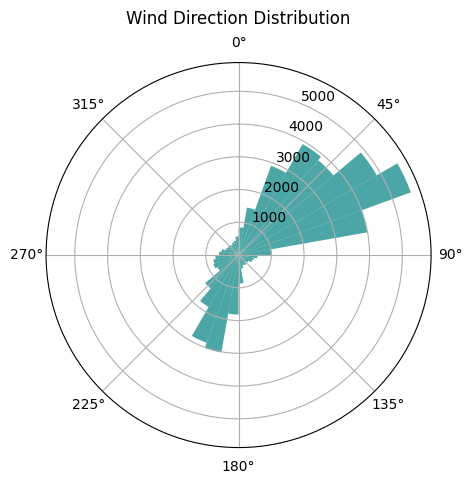

In [8]:
theta = np.deg2rad(df['Wind Direction (°)'])
plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N') # theta0= North
ax.set_theta_direction(-1) # # Clockwise rotation (like a wind map)
ax.hist(theta, bins=36, color='teal', alpha=0.7)
ax.set_title('Wind Direction Distribution', va = 'bottom')
plt.show()

The polar histogram illustrates the distribution of wind directions recorded by the turbine. Most winds come from the east and northeast sectors (around 45°–90°), while other directions occur much less frequently. This indicates that the site experiences a dominant easterly wind pattern, which is important for understanding turbine orientation and evaluating power generation performance.


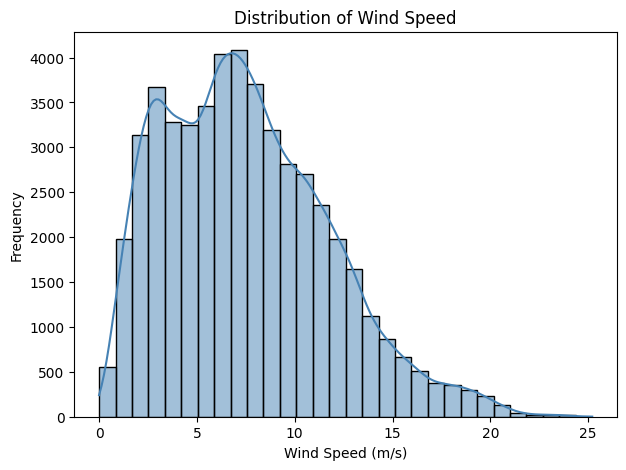

In [9]:
plt.figure(figsize=(7,5))
sns.histplot(df['Wind Speed (m/s)'], bins = 30, color = 'steelblue', kde=True)
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.show()

The histogram shows that most wind speeds range between 3 m/s and 10 m/s, with a clear right-skewed distribution. Low wind speeds are common, while high speeds above 15 m/s occur rarely.

Wind direction is a **circular variable** where 0° and 360° represent the same point.  
Using raw angles in regression models creates artificial discontinuities and incorrect distances.

By converting direction θ into its sine and cosine components:

$$
\text{wd\_sin} = \sin(\theta), \quad \text{wd\_cos} = \cos(\theta)
$$

we:
- Preserve the circular geometry (0° ≡ 360°)  
- Ensure continuity and correct distance metrics  
- Provide models with physically meaningful vector components of wind direction

This transformation improves both numerical stability and model interpretability.

In [10]:
df['wind_sin'] = np.sin(np.deg2rad(df['Wind Direction (°)']))
df['wind_cos'] = np.cos(np.deg2rad(df['Wind Direction (°)']))

In [11]:
X = df.loc[:,['Wind Speed (m/s)', 'wind_sin', 'wind_cos']]
y = df.loc[:,['LV ActivePower (kW)']]
print(X.head())
print(y.head())

   Wind Speed (m/s)  wind_sin  wind_cos
0          5.311336 -0.984792 -0.173736
1          5.672167 -0.999719 -0.023715
2          5.216037 -0.998998  0.044749
3          5.659674 -0.999759  0.021956
4          5.577941 -0.997151 -0.075426
   LV ActivePower (kW)
0           380.047791
1           453.769196
2           306.376587
3           419.645905
4           380.650696


To prevent data leakage, the dataset was chronologically ordered and split into training (70%) and testing (30%) subsets based on time, ensuring that earlier observations were used for model training and later ones for evaluation.

In [12]:
split_index = int(len(df)*0.7)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

As a baseline model, a linear regression is fitted on the standardized predictors

In [64]:
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)
y_predicted_reg = model_reg.predict(X_test)
mae_reg = mean_absolute_error(y_test, y_predicted_reg)
mse_reg = mean_squared_error(y_test, y_predicted_reg)
rmse_reg = np.sqrt(mse_reg)
r2score_reg = r2_score(y_test, y_predicted_reg)
print(f"MAE : {mae_reg:.3f}")
print(f"MSE : {mse_reg:.3f}")
print(f"RMSE : {rmse_reg:.3f}")
print(f"R2 : {r2score_reg:.4f}")

MAE : 406.403
MSE : 276589.818
RMSE : 525.918
R2 : 0.8422


The linear regression model was trained using wind speed and direction features to predict the turbine’s active power output.
Evaluation on the test set shows MAE = 406.4, RMSE = 525.9, and R² = 0.842, indicating that a simple linear relationship explains most of the power variation but still leaves noticeable residual error, suggesting the presence of nonlinear effects in the data.

In [65]:
model_rfr = RandomForestRegressor(random_state=1)
model_rfr.fit(X_train, y_train.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
y_predicted_rfr = model_rfr.predict(X_test)

In [67]:
mae_rfr = mean_absolute_error(y_test, y_predicted_rfr)
mse_rfr = mean_squared_error(y_test, y_predicted_rfr)
rmse_rfr = np.sqrt(mse_rfr)
r2score_rfr = r2_score(y_test, y_predicted_rfr)
print(f"MAE : {mae_rfr:.3f}")
print(f"MSE : {mse_rfr:.3f}")
print(f"RMSE : {rmse_rfr:.3f}")
print(f"R2 : {r2score_rfr:.4f}")

MAE : 250.008
MSE : 295467.985
RMSE : 543.570
R2 : 0.8314


The Random Forest model achieved a lower mean absolute error (MAE = 250.0) than the linear model (MAE = 406.4), indicating better average prediction accuracy.
However, its RMSE (543.6) and R² (0.831) are slightly worse than the linear regression (RMSE = 525.9 kW, R² = 0.842), suggesting that while Random Forest reduces typical errors, it occasionally produces larger deviations and does not improve overall variance explanation.


In [68]:
param_grid = {
    'n_estimators' : [200, 250],
     'max_depth' : [10, 20],
     'min_samples_split' : [10, 15],
     'min_samples_leaf': [20, 30]
}

In [69]:
model_rfr_cv=GridSearchCV(estimator=model_rfr, param_grid=param_grid, 
                       cv = 3, scoring='neg_mean_squared_error', n_jobs=-1)

In [70]:
model_rfr_cv.fit(X_train, y_train.values.ravel())

,estimator,RandomForestR...andom_state=1)
,param_grid,"{'max_depth': [10, 20], 'min_samples_leaf': [20, 30], 'min_samples_split': [10, 15], 'n_estimators': [200, 250]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,250


In [71]:
print(model_rfr_cv.best_params_)
print("Best CV score:", model_rfr_cv.best_score_)

{'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 10, 'n_estimators': 250}
Best CV score: -218267.69502187616


In [72]:
y_predicted_rfr_cv = model_rfr_cv.predict(X_test)
mae_rfr_cv = mean_absolute_error(y_test, y_predicted_rfr_cv)
mse_rfr_cv = mean_squared_error(y_test, y_predicted_rfr_cv)
rmse_rfr_cv = np.sqrt(mse_rfr_cv)
r2score_rfr_cv = r2_score(y_test, y_predicted_rfr_cv)
print(f"MAE : {mae_rfr_cv:.3f}")
print(f"MSE : {mse_rfr_cv:.3f}")
print(f"RMSE : {rmse_rfr_cv:.3f}")
print(f"R2 : {r2score_rfr_cv:.4f}")

MAE : 235.231
MSE : 245799.690
RMSE : 495.782
R2 : 0.8598


The Random Forest model was optimized using 3-fold cross-validation and a grid search over key hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf). On the test set, the tuned model reached MAE = 235.2, RMSE = 495.8, and R² = 0.8598, showing improved accuracy and generalization compared to the untuned Random Forest and simple linear regression.

In [80]:
tf.random.set_seed(42)
np.random.seed(42)

model_tf = keras.Sequential([
    layers.Input(shape=(3,)),                 
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(32, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(1, activation='linear')
])

model_tf.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])
model_tf.fit(X_train, y_train, epochs=100)

Epoch 1/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1205.3876 - mae: 1205.3876
Epoch 2/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1069.1379 - mae: 1069.1379
Epoch 3/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 850.6839 - mae: 850.6839
Epoch 4/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 605.0372 - mae: 605.0372
Epoch 5/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 373.1300 - mae: 373.1300
Epoch 6/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 270.6329 - mae: 270.6329
Epoch 7/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 261.5738 - mae: 261.5738
Epoch 8/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 260.5497 - mae: 260.5497
Epoch 9/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 259.7777 - mae: 259.7777
Epoch 10/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 259.0693 - mae: 259.0693
Epoch 11/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 258.3002 - mae: 258.3002
Epoch 12/100
1106/1106 ━━━

In [81]:
y_predicted_tf = model_tf.predict(X_test)
mae_tf = mean_absolute_error(y_test, y_predicted_tf)
mse_tf = mean_squared_error(y_test, y_predicted_tf)
rmse_tf = np.sqrt(mse_tf)
r2score_rfr_cv = r2_score(y_test, y_predicted_tf)
print(f"MAE : {mae_tf:.3f}")
print(f"MSE : {mse_tf:.3f}")
print(f"RMSE : {rmse_tf:.3f}")
print(f"R2 : {r2score_rfr_cv:.4f}")

474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE : 202.179
MSE : 126969.531
RMSE : 356.328
R2 : 0.9276


The neural network model, built with two hidden layers (64 and 32 neurons) and trained using the Adam optimizer with MAE loss.
On the test data, it reached MAE = 202.2, RMSE = 356.3, and R² = 0.9276, indicating strong predictive capability and effective capture of nonlinear relationships between wind speed, direction, and turbine active power.
The low error metrics and high R² demonstrate that the neural network generalizes well and accurately models the underlying turbine power curve.

In [27]:
model_sr=PySRRegressor(
    niterations=1000, # Number of evolutionary search iterations 
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['sin', 'cos', 'exp', 'log', 'square'],
    extra_sympy_mappings={'square': lambda x: x**2},    # Custom mapping for user-defined operators (e.g., square = x**2)
    model_selection = 'best',                          # Select the best equation based on validation performance
    elementwise_loss='L2DistLoss()',                   # Loss function: L2 (Mean Squared Error)
    maxsize=10,                                        # Maximum expression size (controls equation complexity)
    maxdepth=6,                                        # Maximum depth of the expression tree
    populations=10,                                    # Number of populations used in the evolutionary algorithm
    procs=0,                                           # Number of CPU cores to use (0 = use all available cores)
    deterministic=True,                                # ensures reproducibility
    parallelism="serial",                              # disable nondeterministic parallelism
    batching=True,                                     # enable batching for >10k samples
    batch_size=1000,                                   # number of samples per mini-batch
    progress=False,
)

model_sr.fit(X_train, y_train.values)

C:\Users\arefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\pysr\sr.py:2890: UserWarning: `numprocs` is specified but will be ignored since `parallelism='serial'`
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.370e+03
Progress: 230 / 10000 total iterations (2.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.689e+06  0.000e+00  y = 1228.9
3           4.553e+05  6.005e-01  y = x₀ * 4916.1
5           2.948e+05  1.938e-01  y = (x₀ * 6934.2) + -796.63
7           2.948e+05  -0.000e+00  y = ((x₁ + 6952.5) * x₀) - 800.1
8           2.667e+05  6.625e-02  y = square((-148.22 - (x₀ * -84.582)) * x₀)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.100e+03
Progress: 516 / 10000 total iterations (5.160%)
══════════════

[ Info: Final population:
[ Info: Results saved to:


,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,"['sin', 'cos', ...]"
,expression_spec,None
,niterations,1000
,populations,10
,population_size,27
,max_evals,None
,maxsize,10
,maxdepth,6
,warmup_maxsize_by,None


  - outputs\20251106_151527_wT3xZ6\hall_of_fame.csv


In [28]:
eqs = model_sr.equations_
print(eqs.head())

print("Best equation:" , model_sr.sympy())

   complexity        loss                                equation     score  \
0           1  1688693.50                               1228.3295  0.000000   
1           3   455319.12                           x0 * 4901.099  0.655356   
2           5   294810.12             (x0 * 6934.1807) + -795.304  0.217334   
3           6   285515.84       (sin(x0) * 7502.195) + -894.73785  0.032034   
4           7   227381.25  sin(square(x0) * 3.2987351) * 4050.399  0.227669   

                    sympy_format  \
0               1228.32950000000   
1                    x0*4901.099   
2         x0*6934.1807 - 795.304   
3   sin(x0)*7502.195 - 894.73785   
4  sin(x0**2*3.2987351)*4050.399   

                                    lambda_format  
0               PySRFunction(X=>1228.32950000000)  
1                    PySRFunction(X=>x0*4901.099)  
2         PySRFunction(X=>x0*6934.1807 - 795.304)  
3   PySRFunction(X=>sin(x0)*7502.195 - 894.73785)  
4  PySRFunction(X=>sin(x0**2*3.2987351)*4050.399

In [29]:
y_predicted_sr = model_sr.predict(X_test)
mae_sr = mean_absolute_error(y_test, y_predicted_sr)
mse_sr = mean_squared_error(y_test, y_predicted_sr)
rmse_sr = np.sqrt(mse_sr)
r2score_sr = r2_score(y_test, y_predicted_sr)
print(f"MAE : {mae_sr:.3f}")
print(f"MSE : {mse_sr:.3f}")
print(f"RMSE : {rmse_sr:.3f}")
print(f"R2 : {r2score_sr:.4f}")

MAE : 319.153
MSE : 196351.760
RMSE : 443.116
R2 : 0.8880


The symbolic regression model was trained using 1,000 evolutionary iterations with trigonometric and polynomial operators to discover interpretable mathematical expressions for turbine power output.
The best equation found was
$$power = sin((windspeed)² * 3.2987) × 4050.4$$
which captures a nonlinear periodic relationship mainly driven by wind speed.
On the test data, the model achieved MAE = 319.2, RMSE = 443.1, and R² = 0.888, showing a clear improvement compared to the linear model and earlier symbolic runs.
This result indicates that PySR successfully identified a compact nonlinear expression that balances interpretability with predictive accuracy, closely approximating the turbine’s true power curve.

**Conclusion**

Among all tested models, the neural network achieved the best overall performance with the lowest MAE (202.17), lowest RMSE (356.32), and highest R² (0.9276), indicating strong ability to capture nonlinear relationships between wind features and turbine power.
The random forest also performed well, improving over the linear model by reducing average error while maintaining good generalization (R² = 0.8598).
The symbolic regression produced a simpler, interpretable nonlinear equation with reasonable accuracy (R² = 0.8880), offering insight into the underlying physical relationship.
Overall, while the neural network provides the most accurate predictions, the symbolic regression offers the best trade-off between interpretability and performance.